# Icentia11k-05-datasets.ipynb  
Create TensorFlow datasets from downloaded sequences  
See https://physionet.org/content/icentia11k-continuous-ecg/1.0/  

In [40]:
# Environment setup.
import glob
import os
import re
import sys
import tensorflow as tf
import wfdb
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

import fileutils as fu
import icentia11k as ic
import icentia11k_tfrecord as tfr

print('Numpy version:      {}'.format(np.__version__))
print('TensorFlow version: {}'.format(tf.__version__))
print('You are here: {}'.format(os.getcwd()))

Numpy version:      1.23.2
TensorFlow version: 2.10.0
You are here: D:\dev\jupyter\Icentia11k


In [41]:
# ECG data parameters.
tfr.ECG_LENGTH = 7500
tfr.ECG_OFFSET = 1250
tfr.USE_ZNORM  = True

In [42]:
# File name regular expression patterns.
wfdb_dat_file_pat = re.compile('(p\d{5})_(s\d{2})_([A-Z]+)_(\d{7})_(\d{7})\.dat')
tfrecord_file_pat = re.compile('(p\d{5})_(s\d{2})_([A-Z]+)_(\d{7})_(\d{7})\.tfrecord')

In [43]:
# Function to convert label string to a number.
def label_num(label):
    return ic.LABELS[str(label).upper()]

In [44]:
# Function to parse a WFDB ECG file name.
def parse_wfdb_filename(filename):
    m = wfdb_dat_file_pat.match(filename)
    is_file = False
    pid = ''
    sid = ''
    rtype = ''
    start = 0
    length = 0
    if m:
        is_file = True
        pid = m.group(1)
        sid = m.group(2)
        rtype = m.group(3)
        start = int(m.group(4))
        length = int(m.group(5))
    return (is_file, pid, sid, rtype, start, length)

In [45]:
# Function to create a tfrecord path and filename from component parts.
def get_tfrecord_filename(pid, sid, rtype, start, length):
    pid = pid[1:]
    sid = sid[1:]
    topdir, pid_dir = ic.get_pid_dirs(pid) 
    path = os.path.join(ic.LOCAL_TFRECORD_PATH, topdir, pid_dir)
    filename = ic.get_tfrecord_filename(pid, sid, rtype, start, length)
    return (path, filename)

In [46]:
# Function to convert a WFDB ECG data file to a tfrecord data file.
def wfdb_to_tfrecord(src, label, dst, offset=0):
    
    lnum = ic.LABELS[str(label).upper()]
    one_hot = np.zeros(len(ic.LABELS))
    one_hot[lnum] = 1.
    
    # Get the WFDB ECG record.
    if (src.endswith('.dat')):
        src = src[:-4] # Remove file extension
    rec = wfdb.rdrecord(src)
    #ic.pprint(rec.__dict__)
    
    ecg_raw = rec.p_signal.flatten().astype(np.float32)[offset:]
    ecg_std = np.std(ecg_raw)
    ecg_znorm = stats.zscore(ecg_raw)
    raw_sum = np.sum(ecg_raw)
    znorm_sum = np.sum(ecg_znorm)
    
    # Perform a data check.
    if np.isinf(raw_sum):
        print('ECG raw contains +/-inf, {} not created.'.format(dst))
        print('Source: {}'.format(src))
        return 0
    if np.isnan(raw_sum):
        print('ECG raw contains NaN, {} not created.'.format(dst))
        print('Source: {}'.format(src))
        return 0
    if np.isinf(znorm_sum):
        print('ECG Z-Norm contains +/-inf, {} not created.'.format(dst))
        print('Source: {}'.format(src))
        print('Std: {:0.4f}'.format(ecg_std))
        return 0
    if np.isnan(znorm_sum):
        print('ECG Z-Norm contains NaN, {} not created.'.format(dst))
        print('Source: {}'.format(src))
        print('Std: {:0.4f}'.format(ecg_std))
        return 0
    
    # Create the map of data to feature proto objects.
    feature = {}
    feature['ecg_raw'] = tf.train.Feature(float_list=tf.train.FloatList(value=ecg_raw))
    feature['ecg_znorm'] = tf.train.Feature(float_list=tf.train.FloatList(value=ecg_znorm))
    #feature['label'] = tf.train.Feature(int64_list=tf.train.Int64List(value=[lnum]))
    feature['one_hot'] = tf.train.Feature(float_list=tf.train.FloatList(value=one_hot))
    #ic.pprint(feature)
    
    # Construct the Example proto object.
    example = tf.train.Example(features=tf.train.Features(feature=feature))

    # Serialize the example to a string.
    serialized = example.SerializeToString()

    # Write the serialized object to the disk
    with tf.io.TFRecordWriter(dst) as writer:
        writer.write(serialized)
    return 1

### Create a dummy TFRecord file and read it back  

In [47]:
# Create a dummy tfrecord file.
ecg_src = os.path.join(ic.LOCAL_DATA_PATH, 'p00/p00010/p00010_s00_AFL_0000000_0008750.dat')
tfr_dst = 'dummy.tfrecord'
wfdb_to_tfrecord(ecg_src, 'AFL', tfr_dst, offset=tfr.ECG_OFFSET)

1

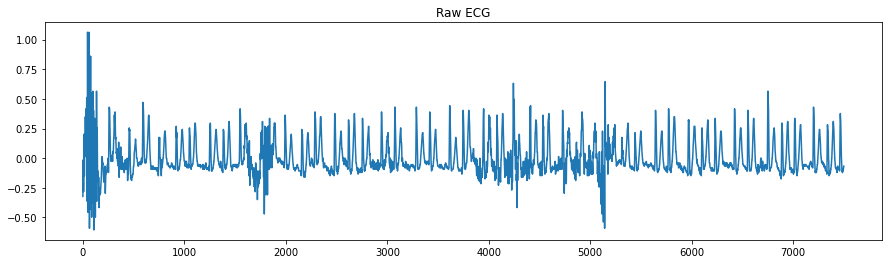

Samples: 7500
One-Hot: [0. 0. 1. 0.]
Mean:    0.0030
Stdev:   0.1450


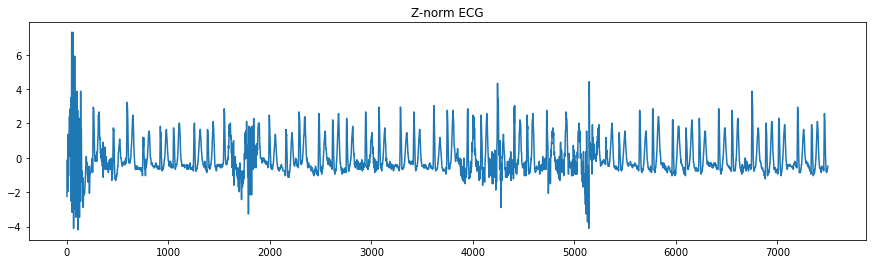

Samples: 7500
One-Hot: [0. 0. 1. 0.]
Mean:    -0.0000
Stdev:   1.0000


In [48]:
# Read it back and plot the data.
ds = tf.data.TFRecordDataset([tfr_dst])

tfr.USE_ZNORM = False
ds1 = ds.map(tfr.ecg_parse_fn)
for dr1 in ds1.take(1):
    pass
plt.figure(figsize=(15, 4))
plt.plot(dr1[0])
plt.title('Raw ECG')
plt.show()
print('Samples: {}'.format(len(dr1[0])))
print('One-Hot: {}'.format(dr1[1]))
print('Mean:    {:0.4f}'.format(np.mean(dr1[0])))
print('Stdev:   {:0.4f}'.format(np.std(dr1[0])))

tfr.USE_ZNORM = True
ds2 = ds.map(tfr.ecg_parse_fn)
for dr2 in ds2.take(1):
    pass
plt.figure(figsize=(15, 4))
plt.plot(dr2[0])
plt.title('Z-norm ECG')
plt.show()
print('Samples: {}'.format(len(dr2[0])))
print('One-Hot: {}'.format(dr2[1]))
print('Mean:    {:0.4f}'.format(np.mean(dr2[0])))
print('Stdev:   {:0.4f}'.format(np.std(dr2[0])))

### Run this cell to create TFRecord files  
Set batch_size to the maximum number of TFRecord files to create. 

In [70]:
batch_size = 90000

tfrecord_count = 0
offset = tfr.ECG_OFFSET

print('{} TFRecord start.'.format(ic.timestamp()))

for (dirpath, dirs, files) in os.walk(ic.LOCAL_DATA_PATH):
    if (tfrecord_count >= batch_size): break
    for file in files:
        (is_file, pid, sid, rtype, start, length) = parse_wfdb_filename(file)
        if is_file:
            (tf_path, tf_file) = get_tfrecord_filename(pid, sid, rtype, start+offset, length-offset)
            tf_fullpath = os.path.join(tf_path, tf_file)
            if not os.path.isfile(tf_fullpath):
                fu.mkpath(tf_path) # Create path if needed
                tfrecord_count += wfdb_to_tfrecord(
                    os.path.join(dirpath, file),
                    rtype,
                    os.path.join(tf_path, tf_file),
                    offset=offset
                )
        if (tfrecord_count >= batch_size): break

print('{} TFRecord complete.'.format(ic.timestamp()))
print('{} TFRecord files created.'.format(tfrecord_count))

2023-08-02 15:05:13 TFRecord start.
2023-08-02 16:57:02 TFRecord complete.
80000 TFRecord files created.


### Run this cell to count the number of TFRecord files

In [71]:
tfrecord_count = 0
for (dirpath, dirs, files) in os.walk(ic.LOCAL_TFRECORD_PATH):
    for file in files:
        if tfrecord_file_pat.match(file):
            tfrecord_count += 1
print('Total TFRecords: {}'.format(tfrecord_count))

Total TFRecords: 600000


### Create train, test, and validation lists

In [78]:
train_list, test_list, val_list = tfr.create_tfrecord_lists(
    ic.LOCAL_TFRECORD_PATH,
    ic.LOCAL_DATA_PATH,
    test_split=0.02,
    val_split=0.02,
    max_records=400000,
    seed=12345
)

train_size = len(train_list)
test_size = len(test_list)
val_size = len(val_list)

print('Train size:      {}'.format(train_size))
print('Test size:       {}'.format(test_size))
print('Validation size: {}'.format(val_size))

if (train_size > 0): print(train_list[0])
if (test_size > 0): print(test_list[0])
if (val_size > 0): print(val_list[0])

Train size:      384000
Test size:       8000
Validation size: 8000
E:/Data/Icentia11k/tfrecord\p00\p00016\p00016_s24_AFIB_0466488_0007500.tfrecord
E:/Data/Icentia11k/tfrecord\p01\p01230\p01230_s28_Q_0467022_0007500.tfrecord
E:/Data/Icentia11k/tfrecord\p04\p04849\p04849_s06_N_0001250_0007500.tfrecord


### Analyze the file lists to ensure an even distribution of rhythm types

In [79]:
def analyze_list(file_list):
    missing_files = 0
    tfrecord_file_pat = re.compile(ic.TFRECORD_FILE_RE)
    afib_array = np.zeros(ic.NUM_PATIENTS, dtype=np.int32)
    afl_array = np.zeros(ic.NUM_PATIENTS, dtype=np.int32)
    n_array = np.zeros(ic.NUM_PATIENTS, dtype=np.int32)
    q_array = np.zeros(ic.NUM_PATIENTS, dtype=np.int32)
    for file in file_list:
        if not os.path.isfile(file):
            print('File does not exist: {}'.format(file))
            missing_files += 1
        m = tfrecord_file_pat.search(file)
        if m:
            pid = int(m.group(1)[1:])
            rtype = m.group(3)
            if (rtype == 'AFIB'):
                afib_array[pid] += 1
            elif (rtype == 'AFL'):
                afl_array[pid] += 1
            elif (rtype == 'N'):
                n_array[pid] += 1
            elif (rtype == 'Q'):
                q_array[pid] += 1
    histo_sum, histo_cnt, histo_min, histo_avg, histo_max = ic.get_histo_stats(afib_array)
    print('AFIB: Seq: {:6d} PIDs: {:5d}  min: {:3d}  avg: {:6.1f}  max: {:4d}'.format(
            histo_sum, histo_cnt, histo_min, histo_avg, histo_max))
    histo_sum, histo_cnt, histo_min, histo_avg, histo_max = ic.get_histo_stats(afl_array)
    print(' AFL: Seq: {:6d} PIDs: {:5d}  min: {:3d}  avg: {:6.1f}  max: {:4d}'.format(
            histo_sum, histo_cnt, histo_min, histo_avg, histo_max))
    histo_sum, histo_cnt, histo_min, histo_avg, histo_max = ic.get_histo_stats(n_array)
    print('   N: Seq: {:6d} PIDs: {:5d}  min: {:3d}  avg: {:6.1f}  max: {:4d}'.format(
            histo_sum, histo_cnt, histo_min, histo_avg, histo_max))
    histo_sum, histo_cnt, histo_min, histo_avg, histo_max = ic.get_histo_stats(q_array)
    print('   Q: Seq: {:6d} PIDs: {:5d}  min: {:3d}  avg: {:6.1f}  max: {:4d}'.format(
            histo_sum, histo_cnt, histo_min, histo_avg, histo_max))
    if (missing_files > 0):
        print('Total missing files: {}'.format(missing_files))

print('Training list:')
analyze_list(train_list)
print('\nTest list:')
analyze_list(test_list)
print('\nValidation list:')
analyze_list(val_list)

Training list:
File does not exist: E:/Data/Icentia11k/tfrecord\p09\p09427\p09427_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p09\p09428\p09428_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p09\p09429\p09429_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p09\p09430\p09430_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p09\p09431\p09431_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p09\p09432\p09432_s08_N_0065439_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p09\p09433\p09433_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p09\p09434\p09434_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p09\p09435\p09435_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p09\p09436\p09436_s08_N_0001250_0007500.tfrecord
File 

File does not exist: E:/Data/Icentia11k/tfrecord\p09\p09673\p09673_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p09\p09674\p09674_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p09\p09675\p09675_s09_N_0009676_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p09\p09676\p09676_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p09\p09677\p09677_s08_N_0006500_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p09\p09678\p09678_s10_N_0035337_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p09\p09679\p09679_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p09\p09680\p09680_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p09\p09681\p09681_s10_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p09\p09682\p09682_s08_N_0004577_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10084\p10084_s12_N_0307463_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10085\p10085_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10086\p10086_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10087\p10087_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10088\p10088_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10089\p10089_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10090\p10090_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10091\p10091_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10092\p10092_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10093\p10093_s11_N_0001250_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10221\p10221_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10222\p10222_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10223\p10223_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10224\p10224_s10_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10225\p10225_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10226\p10226_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10227\p10227_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10229\p10229_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10230\p10230_s08_N_0008742_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10231\p10231_s08_N_0001250_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10634\p10634_s17_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10635\p10635_s08_N_0009680_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10636\p10636_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10637\p10637_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10638\p10638_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10639\p10639_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10640\p10640_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10641\p10641_s09_N_0062219_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10642\p10642_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10643\p10643_s08_N_0006470_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10808\p10808_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10809\p10809_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10810\p10810_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10811\p10811_s08_N_0005074_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10812\p10812_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10814\p10814_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10816\p10816_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10817\p10817_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10819\p10819_s08_N_0188940_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10820\p10820_s08_N_0001250_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10960\p10960_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10961\p10961_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10962\p10962_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10963\p10963_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10965\p10965_s11_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10970\p10970_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10971\p10971_s08_N_0008868_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10972\p10972_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10973\p10973_s08_N_0047139_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10974\p10974_s09_N_0168081_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00360\p00360_s11_N_0007183_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00361\p00361_s09_N_0005960_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00362\p00362_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00363\p00363_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00364\p00364_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00366\p00366_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00367\p00367_s09_N_0123522_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00368\p00368_s09_N_0512943_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00369\p00369_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00370\p00370_s09_N_0005955_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00593\p00593_s09_N_0005346_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00594\p00594_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00596\p00596_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00597\p00597_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00598\p00598_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00599\p00599_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00600\p00600_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00601\p00601_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00602\p00602_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00603\p00603_s09_N_0001250_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00710\p00710_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00711\p00711_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00712\p00712_s09_N_0123824_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00713\p00713_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00714\p00714_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00715\p00715_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00716\p00716_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00717\p00717_s09_N_0003263_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00718\p00718_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00720\p00720_s09_N_0001250_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01098\p01098_s09_N_0003191_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01099\p01099_s09_N_0011733_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01102\p01102_s09_N_0047766_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01103\p01103_s09_N_0008210_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01104\p01104_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01105\p01105_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01106\p01106_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01107\p01107_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01108\p01108_s09_N_0017928_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01109\p01109_s09_N_0003479_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01243\p01243_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01244\p01244_s09_N_0009604_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01245\p01245_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01246\p01246_s09_N_0225479_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01247\p01247_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01248\p01248_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01249\p01249_s09_N_0077269_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01250\p01250_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01251\p01251_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01252\p01252_s09_N_0001250_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01343\p01343_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01344\p01344_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01345\p01345_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01346\p01346_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01347\p01347_s09_N_0086446_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01348\p01348_s09_N_0007472_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01349\p01349_s09_N_0087100_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01350\p01350_s09_N_0027671_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01351\p01351_s09_N_0081418_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01352\p01352_s09_N_0001250_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01785\p01785_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01786\p01786_s10_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01787\p01787_s09_N_0208220_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01788\p01788_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01789\p01789_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01790\p01790_s09_N_0009843_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01791\p01791_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01792\p01792_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01793\p01793_s10_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01794\p01794_s09_N_0001250_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01926\p01926_s09_N_0032354_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01927\p01927_s09_N_0104414_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01928\p01928_s09_N_0025726_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01929\p01929_s09_N_0008626_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01930\p01930_s09_N_0031535_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01931\p01931_s09_N_0019372_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01932\p01932_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01934\p01934_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01935\p01935_s09_N_0006606_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01936\p01936_s09_N_0001250_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02479\p02479_s09_N_0057247_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02480\p02480_s09_N_0032458_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02481\p02481_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02482\p02482_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02483\p02483_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02484\p02484_s09_N_0006304_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02485\p02485_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02486\p02486_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02487\p02487_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02489\p02489_s09_N_0001570_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02926\p02926_s09_N_0003401_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02927\p02927_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02928\p02928_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02929\p02929_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02930\p02930_s09_N_0024768_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02931\p02931_s09_N_0041442_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02932\p02932_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02933\p02933_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02934\p02934_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02935\p02935_s09_N_0001250_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03239\p03239_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03240\p03240_s09_N_0006999_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03241\p03241_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03242\p03242_s09_N_0007292_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03243\p03243_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03246\p03246_s09_N_0038885_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03247\p03247_s09_N_0002716_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03248\p03248_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03249\p03249_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03250\p03250_s09_N_0190995_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03599\p03599_s10_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10157\p10157_s09_Q_0134960_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03600\p03600_s09_N_0041922_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10158\p10158_s08_Q_0324626_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03601\p03601_s09_N_0016508_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10159\p10159_s29_Q_0010399_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03602\p03602_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10160\p10160_s12_Q_0133159_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03603\p03603_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10161\p10161_s09_Q_0097207_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03939\p03939_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10481\p10481_s19_Q_0310274_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03940\p03940_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10482\p10482_s27_Q_1005937_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03941\p03941_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10483\p10483_s13_Q_0222085_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03942\p03942_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10484\p10484_s15_Q_0009046_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03943\p03943_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10485\p10485_s13_Q_0035186_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04294\p04294_s11_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10827\p10827_s17_Q_0113089_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04295\p04295_s09_N_0130903_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10828\p10828_s10_Q_0086390_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04296\p04296_s09_N_0115069_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04297\p04297_s09_N_0033398_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10830\p10830_s15_Q_1007220_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04298\p04298_s09_N_0050015_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10831\p10831_s28_Q_0263422_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04299\p04299_s09_N_0049206_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04517\p04517_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00039\p00039_s19_Q_0015871_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04518\p04518_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00040\p00040_s09_Q_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04520\p04520_s09_N_0016765_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00042\p00042_s22_Q_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04521\p04521_s09_N_0007409_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00043\p00043_s34_Q_0987180_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00044\p00044_s21_Q_0381070_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04523\p04523_s09_N_0001250_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04606\p04606_s18_N_0018948_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04607\p04607_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00125\p00125_s13_Q_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04608\p04608_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00126\p00126_s17_Q_0415355_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04609\p04609_s09_N_0016574_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00127\p00127_s10_Q_0011900_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04610\p04610_s09_N_0015719_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00128\p00128_s10_Q_0166981_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04611\p04611_s09_N_0001250_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04698\p04698_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00211\p00211_s38_Q_0556206_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04699\p04699_s09_N_0049710_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00212\p00212_s15_Q_0377102_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04700\p04700_s09_N_0041442_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00213\p00213_s10_Q_0138974_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04701\p04701_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00214\p00214_s10_Q_0412295_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04702\p04702_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00215\p00215_s14_Q_0946678_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04993\p04993_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00495\p00495_s11_Q_0117375_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04994\p04994_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00496\p00496_s12_Q_0491342_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04995\p04995_s09_N_0071105_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00497\p00497_s10_Q_0334269_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04996\p04996_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00498\p00498_s13_Q_0637164_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04997\p04997_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00499\p00499_s09_Q_0569716_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p05\p05297\p05297_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00795\p00795_s21_Q_0217402_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00796\p00796_s12_Q_0753020_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00797\p00797_s19_Q_0802572_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p05\p05301\p05301_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00798\p00798_s11_Q_0010920_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p05\p05302\p05302_s09_N_0006434_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00799\p00799_s12_Q_0261998_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p05\p05303\p05303_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00800\p00800_s19_Q_0078809_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p05\p05605\p05605_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01089\p01089_s15_Q_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p05\p05606\p05606_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01090\p01090_s09_Q_0042719_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p05\p05607\p05607_s09_N_0089865_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01091\p01091_s11_Q_0177748_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p05\p05608\p05608_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01092\p01092_s31_Q_0824736_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p05\p05609\p05609_s09_N_0006714_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01094\p01094_s14_Q_0072563_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p05\p05912\p05912_s09_N_0004778_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01393\p01393_s09_Q_0160488_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p05\p05913\p05913_s09_N_0005682_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01394\p01394_s31_Q_0356228_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p05\p05914\p05914_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01395\p01395_s38_Q_1007669_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p05\p05915\p05915_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01396\p01396_s18_Q_0346398_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p05\p05916\p05916_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01397\p01397_s10_Q_0001250_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p06\p06018\p06018_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01493\p01493_s16_Q_0021652_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p06\p06019\p06019_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01494\p01494_s10_Q_0022924_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p06\p06020\p06020_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01495\p01495_s09_Q_0357246_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p06\p06021\p06021_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01496\p01496_s11_Q_0087112_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p06\p06022\p06022_s09_N_0012087_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01497\p01497_s13_Q_0473159_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p06\p06506\p06506_s09_N_0002329_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01979\p01979_s16_Q_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p06\p06507\p06507_s09_N_0003835_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01980\p01980_s16_Q_0547984_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p06\p06508\p06508_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01981\p01981_s12_Q_0339196_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p06\p06509\p06509_s10_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01982\p01982_s20_Q_0149970_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p06\p06510\p06510_s09_N_0042455_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01983\p01983_s12_Q_0263070_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p06\p06647\p06647_s15_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02119\p02119_s11_Q_0006421_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p06\p06648\p06648_s09_N_0066344_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02120\p02120_s20_Q_0612443_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p06\p06649\p06649_s09_N_0002845_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02121\p02121_s11_Q_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p06\p06650\p06650_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02122\p02122_s22_Q_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p06\p06651\p06651_s09_N_0010228_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02123\p02123_s24_Q_0009077_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p07\p07049\p07049_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02508\p02508_s16_Q_0004239_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p07\p07050\p07050_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02509\p02509_s09_Q_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p07\p07051\p07051_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02510\p02510_s10_Q_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p07\p07052\p07052_s09_N_0004830_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02511\p02511_s14_Q_0363930_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p07\p07053\p07053_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p07\p07054\p07054_s09_N_0001250_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p07\p07284\p07284_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02728\p02728_s11_Q_0043823_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p07\p07286\p07286_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02729\p02729_s28_Q_0170430_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p07\p07287\p07287_s09_N_0050530_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02730\p02730_s11_Q_0014564_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p07\p07288\p07288_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02731\p02731_s12_Q_0005140_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02732\p02732_s11_Q_0779152_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p07\p07290\p07290_s09_N_0001250_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p07\p07595\p07595_s09_N_0042953_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03028\p03028_s10_Q_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p07\p07596\p07596_s09_N_0003465_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03029\p03029_s10_Q_0051090_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p07\p07597\p07597_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p07\p07598\p07598_s09_N_0181442_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03031\p03031_s14_Q_0147013_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p07\p07599\p07599_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03032\p03032_s12_Q_0041640_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p07\p07600\p07600_s09_N_0003551_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p07\p07954\p07954_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03377\p03377_s11_Q_0206755_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01892\p01892_s44_AFIB_0289469_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p07\p07955\p07955_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03378\p03378_s11_Q_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01904\p01904_s03_AFIB_0026602_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p07\p07956\p07956_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03379\p03379_s17_Q_0722121_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01933\p01933_s18_AFIB_0023750_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p07\p07957\p07957_s09_N_0001250_0007500.tfrecord
File does n

File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02582\p02582_s09_N_0005995_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p09\p09302\p09302_s02_AFIB_0040993_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04929\p04929_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01509\p01509_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00876\p00876_s17_Q_0363153_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p05\p05073\p05073_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p05\p05848\p05848_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02151\p02151_s09_N_0003040_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10366\p10366_s11_Q_0529064_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01998\p01998_s09_N_0012603_0007500.tfrecord
File does not exi

File does not exist: E:/Data/Icentia11k/tfrecord\p05\p05636\p05636_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00572\p00572_s10_N_0214556_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00441\p00441_s09_Q_0279591_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00067\p00067_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00268\p00268_s33_Q_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p08\p08021\p08021_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04651\p04651_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01266\p01266_s09_N_0001623_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p09\p09962\p09962_s08_N_0014070_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00792\p00792_s12_Q_0001250_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04807\p04807_s09_N_0009094_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03596\p03596_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04012\p04012_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00842\p00842_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04539\p04539_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p06\p06303\p06303_s13_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10375\p10375_s08_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00791\p00791_s09_N_0039864_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03636\p03636_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01112\p01112_s21_Q_0425269_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01502\p01502_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01734\p01734_s18_Q_1037109_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p06\p06774\p06774_s09_N_0008267_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02967\p02967_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10527\p10527_s38_Q_0127733_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01159\p01159_s11_Q_0929906_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00304\p00304_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p06\p06772\p06772_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p05\p05365\p05365_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02358\p02358_s12_Q_0007161_0007500.tfrecord
File does not exist:

File does not exist: E:/Data/Icentia11k/tfrecord\p10\p10023\p10023_s08_Q_0516030_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p00\p00739\p00739_s09_N_0041793_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01727\p01727_s09_N_0009853_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01778\p01778_s13_Q_0122660_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p04\p04060\p04060_s09_N_0001250_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p06\p06981\p06981_s09_N_0126237_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p03\p03241\p03241_s31_Q_0237480_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p07\p07759\p07759_s09_N_0018305_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p02\p02828\p02828_s14_Q_0007343_0007500.tfrecord
File does not exist: E:/Data/Icentia11k/tfrecord\p01\p01505\p01505_s09_N_0001250_0007500.tfrecord
File does not exist:

### Create TFRecordDatasets  
Check the ability to create datasets with mapping functions.  
Sum the one-hot vectors to show an even distribution.  
Note that this can take a long time on a slow system, especially when using a hard drive for storage.  

In [ ]:
# Training dataset.
tfr.USE_ZNORM = True
train_ds = tf.data.TFRecordDataset(train_list)
train_ds = train_ds.map(tfr.ecg_parse_fn)

onehot_counts = np.zeros(ic.NUM_CLASSES)
for ds in train_ds:
    onehot_counts += ds[1].numpy()
print(onehot_counts)

# Test dataset.
test_ds = tf.data.TFRecordDataset(test_list)
test_ds = test_ds.map(tfr.ecg_parse_fn)

onehot_counts = np.zeros(ic.NUM_CLASSES)
for ds in test_ds:
    onehot_counts += ds[1].numpy()
print(onehot_counts)

# Validation dataset.
val_ds = tf.data.TFRecordDataset(val_list)
val_ds = val_ds.map(tfr.ecg_parse_fn)

onehot_counts = np.zeros(ic.NUM_CLASSES)
for ds in val_ds:
    onehot_counts += ds[1].numpy()
print(onehot_counts)

#### Check the datasets in more detail   
Look for length, mean, standard deviation errors.  
Look for +/-inf and NaN values.  

In [15]:
def check_records(tfrecord_list):
    for tfrecord in tfrecord_list:
        check_ds = tf.data.TFRecordDataset(tfrecord)
        check_ds = check_ds.map(tfr.ecg_parse_fn)
        for ds in check_ds:
            ecg = ds[0]
            ecg_len = len(ecg)
            ecg_sum = np.sum(ecg)
            ecg_mean = np.mean(ecg)
            ecg_std = np.std(ecg)
            
            if (ecg_len != tfr.ECG_LENGTH):
                print('File: {} length: {}'.format(tfrecord, ecg_len))
            if (abs(ecg_mean) >= 1e-07):
                print('File: {} mean: {}'.format(tfrecord, ecg_mean))
            if (abs(1.0 - ecg_std) >= 1e-06):
                print('File: {} std: {}'.format(tfrecord, ecg_std))
            if np.isinf(ecg_sum):
                print('File: {} +/-inf'.format(tfrecord))
            if np.isnan(ecg_sum):
                print('File: {} NaN'.format(tfrecord))

print('Train list')
check_records(train_list)
print('Test list')
check_records(test_list)
print('Validation list')
check_records(val_list)

Train list
Test list
Validation list


### Create a tarfile of the TFRecords in the train, test and validation lists  
The tarfile can be used to transfer TFRecords to a ML workstation or cloud instance.  
Note that this can also take a long time to run and create a very large file.  

In [16]:
# Make file paths relative to the tfrecord directory.
file = train_list[0]
idx = file.find('tfrecord')
root = file[:idx]

for listfile in [train_list, test_list, val_list]:
    for i in range(len(listfile)):
        file = listfile[i].replace('\\', '/')  # Truncate path and replace Windows separator with POSIX separator
        listfile[i] = file[idx:]

# Create CSV files of the tfrecord lists.
train_file = os.path.join(ic.LOCAL_TFRECORD_PATH, 'tfrecord_train_list.csv')
test_file = os.path.join(ic.LOCAL_TFRECORD_PATH, 'tfrecord_test_list.csv')
val_file = os.path.join(ic.LOCAL_TFRECORD_PATH, 'tfrecord_val_list.csv')
fu.create_file_from_list(train_file, train_list)
fu.create_file_from_list(test_file, test_list)
fu.create_file_from_list(val_file, val_list)
train_file = train_file.replace('\\', '/')[idx:]  # Truncate path and replace Windows separator with POSIX separator
test_file = test_file.replace('\\', '/')[idx:]
val_file = val_file.replace('\\', '/')[idx:]

# Create the tar file and add the TFRecord files.
cwd = os.getcwd()
os.chdir(root)
tarfile = os.path.join(ic.LOCAL_TFRECORD_PATH, 'list_tfrecords.tar')
print('{} Creating tar file.'.format(ic.timestamp()))
file_count = fu.mktar(tarfile, train_list, test_list, val_list, progress=1000)
file_count += fu.addtar(tarfile, [train_file, test_file, val_file])
print('{} Tar file complete.'.format(ic.timestamp()))
print('Total files: {}'.format(file_count))
os.chdir(cwd)

2023-06-21 07:56:26 Creating tar file.
1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 109000 110000 111000 112000 113000 114000 115000 116000 117000 118000 119000 120000 121000 122000 123000 124000 125000 126000 127000 128000 129000 130000 131000 132000 133000 134000 135000 136000 137000 138000 139000 140000 140000
2023-06-21 08:59:43 Tar file complete.
Total files: 140003
